In [12]:
%matplotlib notebook

In [4]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

from os.path import join
import pyvista as pv
import Logger

10.1


In [5]:
smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

handIndicesFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\HandIndices.json'
HeadIndicesFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\HeadIndices.json'

In [6]:
handIndices = json.load(open(handIndicesFile))
headIndices = json.load(open(HeadIndicesFile))



In [7]:
device = torch.device("cuda:0")

verts, faces, aux = load_obj(smplshExampleMeshFile)
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device)

verts_rgb = np.full(verts.shape, 1)[None]  # (1, V, 3)
verts_rgb[:, handIndices, :] = np.array([0,0,1])
verts_rgb[:, headIndices, :] = np.array([0,1,0])
verts_rgb = torch.tensor(verts_rgb)

textures = Textures(verts_rgb=verts_rgb.to(device))

smplshMesh = Meshes([verts], [faces_idx], textures=textures)

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\pytorch3d-0.2.0-py3.6-win-amd64.egg\pytorch3d\io\obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [16]:
verts

tensor([[ 0.0478,  0.5149,  0.0938],
        [ 0.0426,  0.5025,  0.1041],
        [ 0.0533,  0.4972,  0.0954],
        ...,
        [-0.0746, -1.1892,  0.1777],
        [-0.0743, -1.2056,  0.1756],
        [ 0.0621, -1.1923,  0.1128]], device='cuda:0')

In [21]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 8
        s.imgSize = 512
        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
        cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
                shader=SoftPhongShader(
                    device=device, 
                    cameras=cameras,
                    lights=s.lights,
                    blend_params=s.blend_params
                )
#                 shader=SoftSilhouetteShader(
#                     blend_params=s.blend_params
#                     # device=device, 
#                     # cameras=cameras,
#                     # lights=lights
#                 )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
                shader=SoftPhongShader(
                    device=device, 
                    cameras=cameras,
                    lights=s.lights,
                    blend_params=s.blend_params
                )
#                 shader=SoftSilhouetteShader(
#                     blend_params=s.blend_params
#                     # device=device, 
#                     # cameras=cameras,
#                     # lights=lights
#                 )
            )

In [22]:
cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 5

# cfgRef.blurRange = 1e-1
cfgRef.blurRange = 0
cfgRef.imgSize = 1000

renderRef = Renderer(cfgRef)

cfg = RenderingCfg()
cfg.sigma = 1e-7
cfg.noiseLevel = 0.2
# cfg.blurRange = 1e-1
cfg.blurRange = 1e-7

cfg.faces_per_pixel = 5
cfg.imgSize = 1000       
renderSynth = Renderer(cfg)


In [23]:
camRTs = []
for iCam in range(cfg.numCams):
    R, T = look_at_view_transform(2.7, 0, 360 * iCam / cfg.numCams, device=device) 
    camRTs.append({'R':R, 'T':T})

<IPython.core.display.Javascript object>


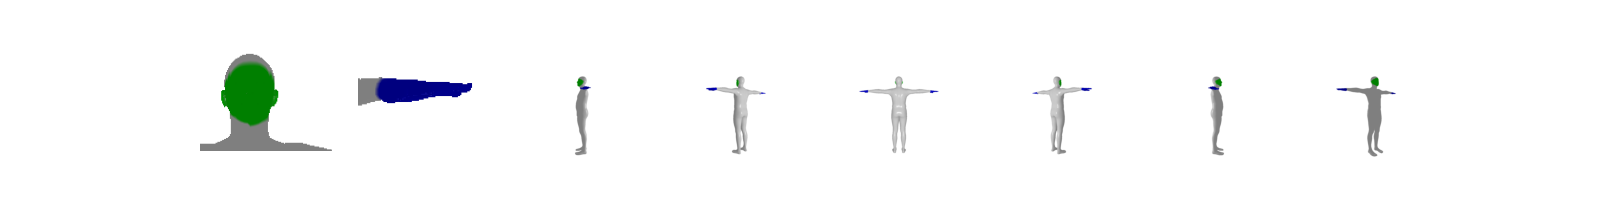

In [25]:
refImgs = []
fig, axs = plt.subplots(1, cfg.numCams)
fig.set_size_inches(cfg.numCams*2, 2)
with torch.no_grad():
    for iCam in range(cfg.numCams):
        R=camRTs[iCam]['R']
        T=camRTs[iCam]['T']
        image = renderRef.renderer(meshes_world=smplshMesh, R=R, T=T).cpu().numpy()
#         image[np.where(image)] = 1
        axs[iCam].imshow(image[0,...,:3], vmin=0.0, vmax=1.0)
        refImgs.append(image)
        axs[iCam].axis('off')

In [14]:
image

array([[[[1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         ...,
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.]],

        [[1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         ...,
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.]],

        [[1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         ...,
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.]],

        ...,

        [[1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         ...,
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.]],

        [[1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         ...,
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.]],

        [[1., 1., 1., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 0.],
         ...,
 